# Análisis exploratorio de datos con todos los dataframes combinados

En esta libreta combinaremos los dataframes del proyecto para realizar un EDA (Exploratory data analysis) y poder encontrar patrones entre las variables agrícolas, económicas y climáticas con respecto a los cultivos en México.

### Librerías

In [151]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import ipywidgets as widgets
import warnings

from ydata_profiling import ProfileReport
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

sns.set_palette('colorblind')
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

%matplotlib inline

### Combinación de los dataframes

Empezaremos por el dataframe del SIAP.

In [2]:
directory = '../limpieza'

df_SIAP = pd.read_csv(os.path.join(directory,"SIAP.csv"))
df_SIAP.head()

,Año,Mes,Cultivo,Estado,Distrito,Municipio,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha)
0,2020,1,Tomate rojo,Aguascalientes,Aguascalientes,Calvillo,16.0,6.0,0.0,90.00,15.00
1,2020,1,Tomate rojo,Baja California,Ensenada,Ensenada,19.5,0.0,0.0,0.00,0.00
2,2020,1,Tomate rojo,Baja California Sur,Mulegé,Mulegé,80.0,0.0,0.0,0.00,0.00
3,2020,1,Tomate rojo,Baja California Sur,Comondú,Comondú,127.0,0.0,0.0,0.00,0.00
4,2020,1,Tomate rojo,Baja California Sur,La Paz,La Paz,611.0,106.0,0.0,4429.76,41.79


En algunos dataframes posteriores a combinar, solo se tienen instancias desglosadas por estado y no por municipio. Por lo tanto, agruparemos por estado y haremos una suma de los valores numéricos, con excepción del rendimiento. Esto se debe a que el SIAP lo calcula dividiendo las columnas 'Producción' y 'Superficie(ha)_Cosechada'. Después de realizar la agrupación, calcularemos el rendimiento. Algunos registros del rendimiento darán NaN, ya que hay registros con 0 producción y 0 cosecha, simplemente los convertimos a *0* numérico.

In [3]:
df_SIAP_state = df_SIAP.groupby(['Año', 'Mes', 'Cultivo', 'Estado']).agg({
    'Superficie(ha)_Sembrada': 'sum',
    'Superficie(ha)_Cosechada': 'sum',
    'Superficie(ha)_Siniestrada': 'sum',
    'Producción': 'sum',
}).reset_index()

# Calculo de 'Rendimiento(udm/ha)' y convertimos los registros NaN a 0
df_SIAP_state['Rendimiento(udm/ha)'] = df_SIAP_state['Producción'] / df_SIAP_state['Superficie(ha)_Cosechada']
df_SIAP_state['Rendimiento(udm/ha)'] = df_SIAP_state['Rendimiento(udm/ha)'].fillna(0)

In [4]:
df_SIAP_state.head(10)

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha)
0,2020,1,Berenjena,Baja California Sur,11.00,0.00,0.0,0.00,0.000000
1,2020,1,Berenjena,Morelos,0.40,0.00,0.0,0.00,0.000000
2,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000
3,2020,1,Berenjena,Quintana Roo,12.50,10.00,0.0,49.00,4.900000
4,2020,1,Berenjena,Sinaloa,1313.50,1073.23,0.0,50629.27,47.174669
5,2020,1,Berenjena,Sonora,76.00,0.00,0.0,0.00,0.000000
6,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000
7,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000
8,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956
9,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000


In [5]:
df_SIAP_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28282 entries, 0 to 28281
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Año                         28282 non-null  int64  
 1   Mes                         28282 non-null  int64  
 2   Cultivo                     28282 non-null  object 
 3   Estado                      28282 non-null  object 
 4   Superficie(ha)_Sembrada     28282 non-null  float64
 5   Superficie(ha)_Cosechada    28282 non-null  float64
 6   Superficie(ha)_Siniestrada  28282 non-null  float64
 7   Producción                  28282 non-null  float64
 8   Rendimiento(udm/ha)         28282 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.9+ MB


In [6]:
columns_to_update = ['Superficie(ha)_Sembrada', 'Superficie(ha)_Cosechada',
					'Superficie(ha)_Siniestrada', 'Producción']
                    
for year in list(df_SIAP_state['Año'].unique()):

    for month in range(12,1,-1):
        
        for state in list(df_SIAP_state['Estado'].unique()):

            for crop in list(df_SIAP_state['Cultivo'].unique()):

                try:
                
                    actual_month = (df_SIAP_state['Año'] == year) & (df_SIAP_state['Mes'] == month) & \
                                   (df_SIAP_state['Estado'] == state) &  (df_SIAP_state['Cultivo'] == crop)
                    previous_month = (df_SIAP_state['Año'] == year) & (df_SIAP_state['Mes'] == month-1) & \
                                     (df_SIAP_state['Estado'] == state) & (df_SIAP_state['Cultivo'] == crop)

                    if(all(df_SIAP_state.loc[actual_month, columns_to_update].values[0] - \
                        df_SIAP_state.loc[previous_month, columns_to_update].values[0] >= 0)):

                        df_SIAP_state.loc[actual_month, columns_to_update] -= \
                        df_SIAP_state.loc[previous_month, columns_to_update].values[0]
                        
                        # df_SIAP_state.loc[actual_month, 'Rendimiento(udm/ha)'] = \
                        # df_SIAP_state.loc[actual_month, 'Producción'] / \
                        # df_SIAP_state.loc[actual_month, 'Superficie(ha)_Cosechada']

                except Exception as e:
                    # print(e)
                    continue

Ahora combinaremos los datos del SIAP con los del SNIIM haciendo un `inner join`. Esto con el objetivo de unificar la información que ya tenemos sobre producción agrícola del SIAP para ahora tener también los precios a la venta por cultivo.

In [7]:
directory = '../limpieza'

df_sniim = pd.read_csv(os.path.join(directory,"df_sniim.csv"))

df_sniim.head()

,Año,Mes,Estado,Cultivo,Precio
0,2020,1,Aguascalientes,Berenjena,19.681818
1,2020,1,Aguascalientes,Brócoli,12.181818
2,2020,1,Aguascalientes,Calabacita,11.393182
3,2020,1,Aguascalientes,Cebolla,6.795455
4,2020,1,Aguascalientes,Chile verde,15.309659


In [8]:
df_sniim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31288 entries, 0 to 31287
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Año      31288 non-null  int64  
 1   Mes      31288 non-null  int64  
 2   Estado   31288 non-null  object 
 3   Cultivo  31288 non-null  object 
 4   Precio   31288 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ MB


In [9]:
df_SIAP_sniim = pd.merge(
    df_SIAP_state,
    df_sniim,
    how="inner",
    on=["Año", "Mes", "Cultivo", "Estado"],
)

df_SIAP_sniim.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio
0,2020,1,Berenjena,Nayarit,60.00,0.0,0.0,0.0,0.000000,26.545455
1,2020,1,Berenjena,Yucatán,28.46,0.0,0.0,0.0,0.000000,5.830000
2,2020,1,Cebolla,Aguascalientes,247.00,7.0,0.0,128.0,18.285714,6.795455
3,2020,1,Cebolla,Baja California Sur,244.25,15.0,0.0,300.0,20.000000,15.484848
4,2020,1,Cebolla,Chiapas,218.53,0.0,0.0,0.0,0.000000,20.954545


In [10]:
df_SIAP_sniim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14200 entries, 0 to 14199
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Año                         14200 non-null  int64  
 1   Mes                         14200 non-null  int64  
 2   Cultivo                     14200 non-null  object 
 3   Estado                      14200 non-null  object 
 4   Superficie(ha)_Sembrada     14200 non-null  float64
 5   Superficie(ha)_Cosechada    14200 non-null  float64
 6   Superficie(ha)_Siniestrada  14200 non-null  float64
 7   Producción                  14200 non-null  float64
 8   Rendimiento(udm/ha)         14200 non-null  float64
 9   Precio                      14200 non-null  float64
dtypes: float64(6), int64(2), object(2)
memory usage: 1.2+ MB


Después agregaremos datos meteorológicos por estado con un `left join`, donde, desde ahora en adelenta, el dataframe de la izquierda será el combiando de los datos del SIAP y SNIIM.

In [11]:
directory = '../limpieza'

df_clima = pd.read_csv(os.path.join(directory,"Data_Climatic_Estatal_Inferido_Clean.csv"))

df_clima.head()

,Año,Mes,Estado,Estado_CVE,Temp_Superficial,Temp_Superficial_MAX,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion
0,2020,1,Aguascalientes,1,11.871672,24.617947,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100
1,2020,1,Baja California,2,11.503548,21.848387,5.296516,12.156581,19.138839,7.561161,3.232000,7.694516,96.414323,2.328968,60.059871,0.225097
2,2020,1,Baja California Sur,3,18.086452,27.860968,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258
3,2020,1,Campeche,4,24.531466,30.339472,20.069032,24.493050,30.125425,19.977243,18.949589,21.721496,100.730762,0.696833,73.750880,1.040616
4,2020,1,Chiapas,7,20.458480,27.968901,15.246714,20.349943,26.273483,15.924568,16.362354,18.356055,91.695314,1.527048,80.520960,1.351758


In [12]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Año                            1472 non-null   int64  
 1   Mes                            1472 non-null   int64  
 2   Estado                         1472 non-null   object 
 3   Estado_CVE                     1472 non-null   int64  
 4   Temp_Superficial               1472 non-null   float64
 5   Temp_Superficial_MAX           1472 non-null   float64
 6   Temp_Superficial_MIN           1472 non-null   float64
 7   Temp_2_Metros                  1472 non-null   float64
 8   Temp_2_Metros_MAX              1472 non-null   float64
 9   Temp_2_Metros_MIN              1472 non-null   float64
 10  Temp_2_Metros_Pto_Congelación  1472 non-null   float64
 11  Temp_2_Metros_Pto_Húmedo       1472 non-null   float64
 12  Presión_Superficial            1472 non-null   f

In [13]:
df_SIAP_sniim_clima = pd.merge(
    df_SIAP_sniim,
    df_clima,
    how="left",
    on=["Año", "Mes", "Estado"],
)
df_SIAP_sniim_clima.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion
0,2020,1,Berenjena,Nayarit,60.00,0.0,0.0,0.0,0.000000,26.545455,...,13.741581,19.796194,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097
1,2020,1,Berenjena,Yucatán,28.46,0.0,0.0,0.0,0.000000,5.830000,...,20.018247,24.568564,30.368262,19.961978,18.301996,21.435265,101.449988,0.637279,70.907876,0.629178
2,2020,1,Cebolla,Aguascalientes,247.00,7.0,0.0,128.0,18.285714,6.795455,...,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100
3,2020,1,Cebolla,Baja California Sur,244.25,15.0,0.0,300.0,20.000000,15.484848,...,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258
4,2020,1,Cebolla,Chiapas,218.53,0.0,0.0,0.0,0.000000,20.954545,...,15.246714,20.349943,26.273483,15.924568,16.362354,18.356055,91.695314,1.527048,80.520960,1.351758


In [14]:
df_SIAP_sniim_clima.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14200 entries, 0 to 14199
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Año                            14200 non-null  int64  
 1   Mes                            14200 non-null  int64  
 2   Cultivo                        14200 non-null  object 
 3   Estado                         14200 non-null  object 
 4   Superficie(ha)_Sembrada        14200 non-null  float64
 5   Superficie(ha)_Cosechada       14200 non-null  float64
 6   Superficie(ha)_Siniestrada     14200 non-null  float64
 7   Producción                     14200 non-null  float64
 8   Rendimiento(udm/ha)            14200 non-null  float64
 9   Precio                         14200 non-null  float64
 10  Estado_CVE                     14200 non-null  int64  
 11  Temp_Superficial               14200 non-null  float64
 12  Temp_Superficial_MAX           14200 non-null 

Incluiremos la precipitación mensual a nivel estatal, también con un `left join`.

In [15]:
directory = '../limpieza'

df_precipitation = pd.read_csv(os.path.join(directory,"precip.csv"))

df_precipitation = df_precipitation.rename(
                    columns={'Precipitacion': 'Precipitación'})


df_precipitation.head()

,Estado,Año,Mes,Precipitación
0,Aguascalientes,2015,1,7.1
1,Baja California,2015,1,21.7
2,Baja California Sur,2015,1,26.0
3,Campeche,2015,1,90.1
4,Coahuila,2015,1,26.4


In [16]:
df_precipitation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3072 entries, 0 to 3071
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Estado         3072 non-null   object 
 1   Año            3072 non-null   int64  
 2   Mes            3072 non-null   int64  
 3   Precipitación  3072 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 96.1+ KB


In [17]:
df_SIAP_sniim_clima_precip = pd.merge(
    df_SIAP_sniim_clima,
    df_precipitation,
    how="left",
    on=["Año", "Mes", "Estado"],
)
df_SIAP_sniim_clima_precip.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación
0,2020,1,Berenjena,Nayarit,60.00,0.0,0.0,0.0,0.000000,26.545455,...,19.796194,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097,60.4
1,2020,1,Berenjena,Yucatán,28.46,0.0,0.0,0.0,0.000000,5.830000,...,24.568564,30.368262,19.961978,18.301996,21.435265,101.449988,0.637279,70.907876,0.629178,29.5
2,2020,1,Cebolla,Aguascalientes,247.00,7.0,0.0,128.0,18.285714,6.795455,...,11.622434,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100,38.5
3,2020,1,Cebolla,Baja California Sur,244.25,15.0,0.0,300.0,20.000000,15.484848,...,17.575806,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258,1.9
4,2020,1,Cebolla,Chiapas,218.53,0.0,0.0,0.0,0.000000,20.954545,...,20.349943,26.273483,15.924568,16.362354,18.356055,91.695314,1.527048,80.520960,1.351758,28.4


In [18]:
df_SIAP_sniim_clima_precip.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14200 entries, 0 to 14199
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Año                            14200 non-null  int64  
 1   Mes                            14200 non-null  int64  
 2   Cultivo                        14200 non-null  object 
 3   Estado                         14200 non-null  object 
 4   Superficie(ha)_Sembrada        14200 non-null  float64
 5   Superficie(ha)_Cosechada       14200 non-null  float64
 6   Superficie(ha)_Siniestrada     14200 non-null  float64
 7   Producción                     14200 non-null  float64
 8   Rendimiento(udm/ha)            14200 non-null  float64
 9   Precio                         14200 non-null  float64
 10  Estado_CVE                     14200 non-null  int64  
 11  Temp_Superficial               14200 non-null  float64
 12  Temp_Superficial_MAX           14200 non-null 

Por último, el índice de volumen físico, el cual nos dice cuanto cultivo hubo de acuerdo al año anterior. De igual forma, lo agregaremos con un `left join`.

In [19]:
directory = '../limpieza'

df_ivf = pd.read_csv(os.path.join(directory,"ivf.csv"))

df_ivf.head()

,Cultivo,Año,Mes,Ivf
0,Berenjena,2015,12,3.88
1,Brócoli,2015,12,39.05
2,Calabacita,2015,12,109.13
3,Cebolla,2015,12,86.09
4,Chile verde,2015,12,134.97


In [40]:
df_SIAP_sniim_clima_precip_ivf = pd.merge(
    df_SIAP_sniim_clima_precip,
    df_ivf,
    how="left",
    on=["Año", "Mes", "Cultivo"],
)
df_SIAP_sniim_clima_precip_ivf.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,Estado_CVE,Temp_Superficial,Temp_Superficial_MAX,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf
0,2020,1,Berenjena,Nayarit,60.00,0.0,0.0,0.0,0.000000,26.545455,18,19.612645,29.083726,13.741581,19.796194,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097,60.4,763
1,2020,1,Berenjena,Yucatán,28.46,0.0,0.0,0.0,0.000000,5.830000,31,24.662450,30.634364,20.018247,24.568564,30.368262,19.961978,18.301996,21.435265,101.449988,0.637279,70.907876,0.629178,29.5,763
2,2020,1,Cebolla,Aguascalientes,247.00,7.0,0.0,128.0,18.285714,6.795455,1,11.871672,24.617947,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100,38.5,115.2
3,2020,1,Cebolla,Baja California Sur,244.25,15.0,0.0,300.0,20.000000,15.484848,3,18.086452,27.860968,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258,1.9,115.2
4,2020,1,Cebolla,Chiapas,218.53,0.0,0.0,0.0,0.000000,20.954545,7,20.458480,27.968901,15.246714,20.349943,26.273483,15.924568,16.362354,18.356055,91.695314,1.527048,80.520960,1.351758,28.4,115.2


In [21]:
df_SIAP_sniim_clima_precip_ivf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14200 entries, 0 to 14199
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Año                            14200 non-null  int64  
 1   Mes                            14200 non-null  int64  
 2   Cultivo                        14200 non-null  object 
 3   Estado                         14200 non-null  object 
 4   Superficie(ha)_Sembrada        14200 non-null  float64
 5   Superficie(ha)_Cosechada       14200 non-null  float64
 6   Superficie(ha)_Siniestrada     14200 non-null  float64
 7   Producción                     14200 non-null  float64
 8   Rendimiento(udm/ha)            14200 non-null  float64
 9   Precio                         14200 non-null  float64
 10  Estado_CVE                     14200 non-null  int64  
 11  Temp_Superficial               14200 non-null  float64
 12  Temp_Superficial_MAX           14200 non-null 

Una vez unidos todos los datasets, lo guardamos en formato CSV para su posterior uso y procedemos a realizar el EDA.

In [22]:
# Guardar en formato csv
df_SIAP_sniim_clima_precip_ivf.to_csv(os.path.join(directory,"excedente_agrícola.csv"))

### EDA con YData Profiling

Primeramente, se genera un reporte automatizado con YData Profiling (antes llamado Pandas Profiling). De esta manera tenemos un análisis rápido de todas las variables en el dataset.

In [23]:
# Se crea el reporte
profile = ProfileReport(df_SIAP_sniim_clima_precip_ivf, title="EDA Automatizado")

# Se visualiza el reporte
#profile.to_notebook_iframe()

# Se guarda el reporte en archivo HTML
profile.to_file("reportes_ydata_profiling/reporte_eda_excedente_agrícola.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\ACF\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
c:\Users\ACF\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
c:\Users\ACF\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
c:\Users\ACF\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:112: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  warnings.warn("The input array could not be properly "
c:\Users\ACF\anaconda3\Lib\site-packages\scipy\stats\_stats_py.p

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Detectando datos faltantes 

Como se puede observar en el reporte de YData Profiling, sólo las variables "Precipitación" y "Ivf" presentan datos faltantes, esto se debe a que esta información sólo se encuentra disponible hasta el año 2022.


In [24]:
# Años donde se presentan los datos faltantes para las variables "Precipitación" y "Ivf"
print(df_SIAP_sniim_clima_precip_ivf[(df_SIAP_sniim_clima_precip_ivf['Precipitación'].isna())]['Año'].unique())
print(df_SIAP_sniim_clima_precip_ivf[(df_SIAP_sniim_clima_precip_ivf['Ivf'].isna())]['Año'].unique())

[2020 2021 2022 2023]
[2023]


### Detectando anomalías

En el reporte de YData Profiling podemos ver los histogramas para cada variable y podemos observar lo siguiente: 
- La variable "Precio" contiene muchas observaciones que se encuentran muy por encima de la media. Se concluye que no se considerarán como datos atípicos ya que existen algunos productos que son de precio alto en el mercado, como la nuez.

In [25]:
plt.boxplot(x=df_SIAP_sniim_clima_precip_ivf['Precio'])
plt.title("Boxplot: variable 'Precio'")
plt.ylabel("Precios por Kg. $MNX")
plt.show()

C:\Users\ACF\AppData\Local\Temp\ipykernel_10692\330054165.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


- Para las variables de producción agrícola: "Superficie(ha)_Sembrada", "Superficie(ha)_Cosechada", "Superficie(ha)_Siniestrada", "Producción" y "Rendimiento(udm/ha)" aparecen muchos datos como outliers ya que existen muchos registros en 0.

In [26]:
plt.boxplot(x=df_SIAP_sniim_clima_precip_ivf['Superficie(ha)_Sembrada'])
plt.title("Boxplot: variable 'Superficie(ha)_Sembrada'")
plt.ylabel("Número de hectáreas")
plt.show()

C:\Users\ACF\AppData\Local\Temp\ipykernel_10692\3428978315.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [27]:
df_SIAP_sniim_clima_precip_ivf[df_SIAP_sniim_clima_precip_ivf['Superficie(ha)_Sembrada']>150000.0]

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf
160,2020,1,Naranja,Veracruz,170352.90,65596.29,0.0,289251.02,4.409564,4.283333,...,24.127395,14.840575,14.877307,16.838930,94.324801,2.139475,80.420341,2.713830,85.2,122.6
3228,2021,1,Naranja,Veracruz,170380.82,19378.42,0.0,288617.70,14.893768,3.993333,...,23.627168,14.844160,14.941984,16.765315,94.275221,2.160400,81.521099,2.821748,85.0,111.7
7171,2022,1,Naranja,Veracruz,170681.02,19136.41,0.0,295955.89,15.465591,6.309524,...,23.217591,13.730940,13.829915,15.812950,94.356249,2.284924,80.005450,2.149924,69.2,123
11144,2023,1,Naranja,Veracruz,170717.07,1237.58,0.0,17697.60,14.300166,9.418788,...,25.278710,15.179752,14.737002,17.106517,94.236945,1.925514,77.224194,0.916059,NaN,NaN


In [28]:
plt.boxplot(x=df_SIAP_sniim_clima_precip_ivf['Superficie(ha)_Cosechada'])
plt.title("Boxplot: variable 'Superficie(ha)_Cosechada'")
plt.ylabel("Número de hectáreas")
plt.show()

C:\Users\ACF\AppData\Local\Temp\ipykernel_10692\189356075.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [29]:
df_SIAP_sniim_clima_precip_ivf[df_SIAP_sniim_clima_precip_ivf['Superficie(ha)_Cosechada']>60000.0]

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf
160,2020,1,Naranja,Veracruz,170352.9,65596.29,0.0,289251.02,4.409564,4.283333,...,24.127395,14.840575,14.877307,16.838930,94.324801,2.139475,80.420341,2.713830,85.2,122.6
740,2020,3,Naranja,Veracruz,0.0,65104.12,0.0,401487.85,6.889084,4.740476,...,29.938542,17.478932,15.694152,19.238451,94.151937,2.179956,69.176967,0.405170,8.1,197.3
7826,2022,3,Naranja,Veracruz,0.0,67307.08,0.0,566297.69,10.936082,4.678788,...,28.702173,15.550064,13.542217,17.380921,94.080167,2.417953,67.221484,0.472231,12.8,189.4
11808,2023,3,Naranja,Veracruz,0.0,90396.93,0.0,718771.58,10.140063,9.656061,...,30.136767,17.972147,16.177543,19.663690,93.948795,2.313366,69.871590,1.529347,NaN,NaN


In [30]:
plt.boxplot(x=df_SIAP_sniim_clima_precip_ivf['Superficie(ha)_Siniestrada'])
plt.title("Boxplot: variable 'Superficie(ha)_Siniestrada'")
plt.ylabel("Número de hectáreas")
plt.show()

C:\Users\ACF\AppData\Local\Temp\ipykernel_10692\3173126166.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [31]:
df_SIAP_sniim_clima_precip_ivf[df_SIAP_sniim_clima_precip_ivf['Superficie(ha)_Siniestrada']>0.0]

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf
34,2020,1,Chile verde,Nayarit,699.85,184.35,3.0,1855.38,10.064443,27.500000,...,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097,60.4,132.8
41,2020,1,Chile verde,Sinaloa,14172.47,8397.18,47.5,248221.90,29.560150,15.306818,...,26.086075,14.460932,9.542079,14.435161,97.763118,1.739211,57.730018,0.771129,21.4,132.8
254,2020,1,Tomate verde,Nayarit,2049.00,701.00,275.0,9026.46,12.876548,15.681818,...,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097,60.4,92.4
309,2020,2,Cebolla,Sonora,92.41,131.00,21.0,3356.12,20.880954,36.900000,...,21.385498,6.977112,1.643875,7.502146,92.576983,2.306691,50.624612,0.790556,25.6,127.6
331,2020,2,Chile verde,Sonora,273.00,605.10,3.0,17593.83,26.063351,35.504049,...,21.385498,6.977112,1.643875,7.502146,92.576983,2.306691,50.624612,0.790556,25.6,138.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13501,2023,8,Chile verde,Guanajuato,0.00,2137.65,45.0,36609.90,21.296407,31.880435,...,26.523913,14.350463,13.474825,16.674081,80.783633,1.910281,70.947090,7.369663,NaN,NaN
13749,2023,8,Tomate rojo,Ciudad de México,0.10,0.60,0.1,48.00,80.000000,20.918804,...,20.961552,11.107097,12.112560,13.796935,75.635363,1.038125,82.438427,13.031411,NaN,NaN
14051,2023,9,Papa,Chihuahua,0.00,332.00,247.0,10361.80,31.879747,29.380000,...,32.562930,17.420761,10.054910,17.344816,83.535935,1.562493,45.749070,1.155622,NaN,NaN
14137,2023,9,Tomate rojo,Nayarit,0.00,11.00,90.0,728.10,45.049165,19.952381,...,29.375467,23.013183,22.445317,24.007833,92.612467,1.242217,83.987850,8.400933,NaN,NaN


In [32]:
plt.boxplot(x=df_SIAP_sniim_clima_precip_ivf['Producción'])
plt.title("Boxplot: variable 'Producción'")
plt.ylabel("Cantidada de toneladas")
plt.show()

C:\Users\ACF\AppData\Local\Temp\ipykernel_10692\242171998.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [33]:
df_SIAP_sniim_clima_precip_ivf[df_SIAP_sniim_clima_precip_ivf['Producción']>500000.0]

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf
5988,2021,9,Manzana,Chihuahua,0.0,22395.36,0.0,502322.65,22.088499,32.500000,...,28.740607,15.498776,11.618562,16.629672,83.519080,1.633473,58.354985,1.370284,46.1,784.5
7826,2022,3,Naranja,Veracruz,0.0,67307.08,0.0,566297.69,10.936082,4.678788,...,28.702173,15.550064,13.542217,17.380921,94.080167,2.417953,67.221484,0.472231,12.8,189.4
11473,2023,2,Naranja,Veracruz,0.0,35253.50,0.0,550183.23,15.562182,11.119298,...,26.215286,14.694843,13.755612,16.717052,94.259656,2.438005,72.941550,0.971599,NaN,NaN
11808,2023,3,Naranja,Veracruz,0.0,90396.93,0.0,718771.58,10.140063,9.656061,...,30.136767,17.972147,16.177543,19.663690,93.948795,2.313366,69.871590,1.529347,NaN,NaN
13986,2023,9,Manzana,Chihuahua,0.0,23723.28,0.0,507223.97,21.590643,36.894048,...,32.562930,17.420761,10.054910,17.344816,83.535935,1.562493,45.749070,1.155622,NaN,NaN


In [34]:
plt.boxplot(x=df_SIAP_sniim_clima_precip_ivf['Rendimiento(udm/ha)'])
plt.title("Boxplot: variable 'Rendimiento(udm/ha)'")
plt.ylabel("Cantidad de toneladas por hectáreas")
plt.show()

C:\Users\ACF\AppData\Local\Temp\ipykernel_10692\1249923129.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [35]:
df_SIAP_sniim_clima_precip_ivf[df_SIAP_sniim_clima_precip_ivf['Rendimiento(udm/ha)']>300.0]

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,...,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf
1440,2020,5,Tomate rojo,Querétaro,62.01,0.00,0.0,6565.48,304.592230,14.647059,...,29.805018,14.017993,9.255341,15.327616,82.081774,2.190376,54.708961,1.702419,34.4,94
1688,2020,7,Tomate rojo,Querétaro,0.00,88.00,0.0,21675.48,334.422379,15.000000,...,27.646613,15.191774,13.579821,17.068011,82.159677,2.072885,69.837957,2.928853,83.3,120.7
1970,2020,8,Tomate rojo,Querétaro,28.75,30.00,0.0,24958.28,392.498677,15.522381,...,26.608674,14.572258,13.895430,16.788369,82.154946,2.353280,73.701935,3.162527,58.6,128.9
2285,2020,9,Tomate rojo,Querétaro,49.23,0.50,0.0,12273.39,439.400194,14.079524,...,24.417130,13.436833,13.134407,15.605241,82.148000,2.248296,77.115185,3.692111,70.3,128.1
4655,2021,5,Tomate rojo,Querétaro,51.22,0.00,0.0,5530.99,341.468614,15.516500,...,29.216810,14.454498,10.728638,15.941595,82.104462,2.410842,59.663889,2.094516,62.9,127.4
5027,2021,6,Tomate rojo,Querétaro,61.43,10.00,0.0,5427.59,359.602883,14.332273,...,25.629500,14.797852,13.641352,16.603463,82.082944,2.143833,72.818000,5.393981,125.2,109.3
5367,2021,7,Pepino,Querétaro,0.00,0.00,0.0,837.98,319.489231,13.254545,...,24.452151,14.562240,14.632204,16.748011,82.269588,2.013280,79.528853,3.471075,84.4,112.8
5400,2021,7,Tomate rojo,Querétaro,17.00,68.50,0.0,19466.59,330.821783,14.984091,...,24.452151,14.562240,14.632204,16.748011,82.269588,2.013280,79.528853,3.471075,84.4,101.7
5774,2021,8,Tomate rojo,Querétaro,0.00,7.00,0.0,7969.59,361.137265,15.196364,...,25.200323,14.538154,14.620842,16.840323,82.181344,2.250824,78.774409,4.754892,131.3,130.1
6143,2021,9,Tomate rojo,Querétaro,18.02,7.00,0.0,3323.79,365.250078,18.911905,...,23.465481,14.064778,14.770556,16.444685,82.146648,1.715222,82.997870,5.225074,158.6,123


### Analizando relación entre variables por visualización

### Relacion de Variable 1 vs 1

In [67]:
columnas_significantes = ['Superficie(ha)_Sembrada','Superficie(ha)_Cosechada','Superficie(ha)_Siniestrada',
    'Producción','Rendimiento(udm/ha)','Precio','Ivf','Temp_Superficial','Temp_Superficial_MAX',
    'Temp_Superficial_MIN','Temp_2_Metros','Temp_2_Metros_MAX','Temp_2_Metros_MIN',
    'Temp_2_Metros_Pto_Congelación','Temp_2_Metros_Pto_Húmedo','Presión_Superficial',
    'Velocidad_Viento','Humedad_Relativa','Precipitacion','Precipitación']

estados = df_SIAP_sniim_clima_precip_ivf['Estado'].unique().tolist()

### Definiendo funcion de graficacion

In [70]:
def grafica(Estados,Variable_1,Variable_2,Año):
    df_mes = df_SIAP_sniim_clima_precip_ivf.groupby(['Año','Mes','Estado']).mean().reset_index()
    df_mes_anno = df_mes[(df_mes['Año'] == Año ) & (df_mes['Estado'] == Estados)]
    
    XX = df_mes_anno[Variable_1]
    YY = df_mes_anno[Variable_2]

    # Calcular la regresión lineal
    A = np.vstack([XX, np.ones(len(XX))]).T
    slope, intercept = np.linalg.lstsq(A, YY, rcond=None)[0]
    regression_line = slope * XX + intercept

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1, 0.2, 0.2]})
    plt.subplots_adjust(wspace=0.5)

    # Subplot de líneas
    ax1.plot(df_mes_anno['Mes'], XX, label=Variable_1)
    ax1.set_xlabel('Mes')
    ax1.set_ylabel(Variable_1)
    ax1.tick_params(axis='y')
    ax1.legend(loc='upper left')

    ax1_twin = ax1.twinx()
    ax1_twin.plot(df_mes_anno['Mes'], YY, color='red', label=Variable_2)
    ax1_twin.set_ylabel(Variable_2)
    ax1_twin.tick_params(axis='y')
    ax1_twin.legend(loc='upper right')

    # Subplot de dispersión
    ax2.scatter(XX, YY)
    ax2.plot(XX, regression_line, color='red', label='Línea de Regresión')
    ax2.set_xlabel(Variable_1)
    ax2.set_ylabel(Variable_2)
    ax2.legend()

    # Subplot de boxplot 1
    sns.boxplot(data=[XX], ax=ax3)
    ax3.set_ylabel(Variable_1)

    # Subplot de boxplot 2
    sns.boxplot(data=[YY], ax=ax4, color='red')
    ax4.set_ylabel(Variable_2)

    # Titulo del gráfico
    plt.suptitle(Variable_1 + ' vs ' + Variable_2 + ' (Aguascalientes, 2020)', fontsize=14)

   # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

In [71]:
widgets.interact(grafica, Estados = estados, Variable_1=columnas_significantes, Variable_2=columnas_significantes,Año=(2020,2023,1))

interactive(children=(Dropdown(description='Estados', options=('Nayarit', 'Yucatán', 'Aguascalientes', 'Baja C…

<function __main__.grafica(Estados, Variable_1, Variable_2, Año)>

### Pairplot General

In [43]:
# Definir el color principal para el pairplot y la línea de regresión
color_main = '#347fab'  # Color principal para el pairplot
color_reg_line = 'red'  # Color para la línea de regresión

# Crear un pairplot con regresión para las columnas numéricas
pairplot = sns.pairplot(df_SIAP_sniim_clima_precip_ivf[columnas_significantes], kind='reg', diag_kind='kde', plot_kws={'color': color_main})
plt.show()

### Analizando correlación entre variables (KEVIN)

### Usando PCA

Para finalizar, aplicaremos un análisis por componentes principales (PCA). Aplicaremos uno agrupando por estado, otro por cultivo y el último sin agrupar. Para los análisis agrupados no tomaremos en cuenta las columnas de tiempo, ya que al agruparlo se pierde la información.

In [152]:
directory = '../limpieza'

df_SIAP_sniim_clima_precip_ivf = pd.read_csv(os.path.join(directory,"excedente_agrícola.csv"))
df_SIAP_sniim_clima_precip_ivf.head()

,Año,Mes,Cultivo,Estado,Superficie(ha)_Sembrada,Superficie(ha)_Cosechada,Superficie(ha)_Siniestrada,Producción,Rendimiento(udm/ha),Precio,Estado_CVE,Temp_Superficial,Temp_Superficial_MAX,Temp_Superficial_MIN,Temp_2_Metros,Temp_2_Metros_MAX,Temp_2_Metros_MIN,Temp_2_Metros_Pto_Congelación,Temp_2_Metros_Pto_Húmedo,Presión_Superficial,Velocidad_Viento,Humedad_Relativa,Precipitacion,Precipitación,Ivf
0,2020,1,Berenjena,Nayarit,60.00,0.00,0.0,0.00,0.000000,26.545455,18,19.612645,29.083726,13.741581,19.796194,26.256194,14.834145,11.615113,15.705790,92.821242,1.488903,63.214177,2.056097,60.4,763.0
1,2020,1,Berenjena,Yucatán,28.46,0.00,0.0,0.00,0.000000,5.830000,31,24.662450,30.634364,20.018247,24.568564,30.368262,19.961978,18.301996,21.435265,101.449988,0.637279,70.907876,0.629178,29.5,763.0
2,2020,1,Brócoli,Aguascalientes,440.00,0.00,0.0,0.00,0.000000,12.181818,1,11.871672,24.617947,3.252815,11.622434,19.955865,4.849208,2.336100,6.980059,79.269296,2.306334,59.219238,0.836100,38.5,138.1
3,2020,1,Brócoli,Baja California,886.46,815.81,0.0,12273.01,15.043956,26.710000,2,11.503548,21.848387,5.296516,12.156581,19.138839,7.561161,3.232000,7.694516,96.414323,2.328968,60.059871,0.225097,4.3,138.1
4,2020,1,Brócoli,Baja California Sur,1.90,0.00,0.0,0.00,0.000000,26.000000,3,18.086452,27.860968,12.222968,17.575806,24.043097,13.045290,10.594581,14.085290,99.619742,2.680968,67.542323,0.050258,1.9,138.1


#### Agrupacion por estado

Haciendo esta agrupación el 92% de la varianza de nuestros datos esta explicada con 5 componentes principiales. El análisis muestra relaciones climatológicas y de producción agrícola entre los estados.  

Varianza explicada acumulada:
[0.4485914  0.67299611 0.83907272 0.8913334  0.92473002 0.95115137
 0.97247439 0.98151445 0.98968057 0.99562321 0.99778145 0.99897741
 0.99974005 0.999863   0.99995282 0.99999308 0.99999877 1.
 1.        ]


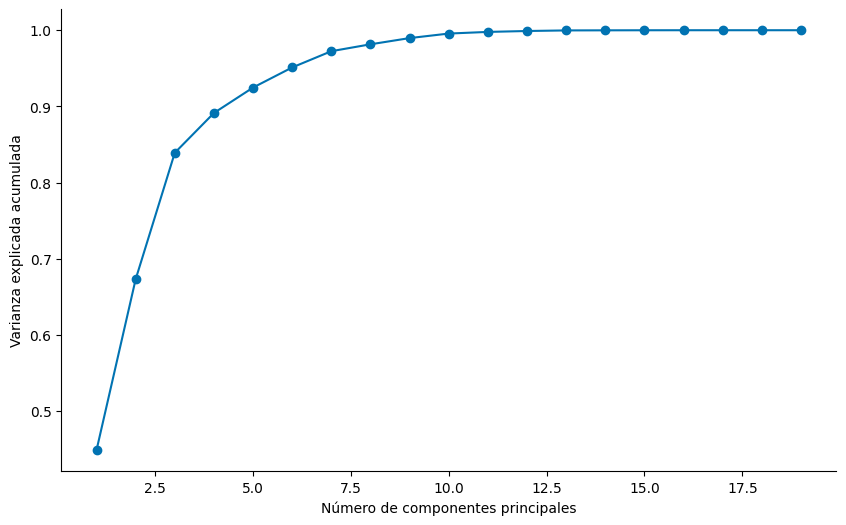

In [153]:
# Eliminamos columnas 
df_group_state = df_SIAP_sniim_clima_precip_ivf.drop(['Año', 'Mes', 'Rendimiento(udm/ha)', 
                                                      'Estado_CVE', 'Cultivo'], axis=1)


# Funciones de agregación 
default_aggregation_function = 'mean'
specific_aggregations = {
    'Superficie(ha)_Sembrada': 'sum',
    'Superficie(ha)_Cosechada': 'sum',
    'Superficie(ha)_Siniestrada': 'sum',
    'Producción': 'sum', 
    'Precipitación': 'sum',
    'Precipitacion': 'sum'
}
aggregation_functions = {col: specific_aggregations.get(col, default_aggregation_function) for col in df_group_state.columns}
aggregation_functions.pop('Estado')

# Hacemos la agrupación por estado
df_group_state = df_group_state.groupby(['Estado']).agg(aggregation_functions).reset_index()
df_to_pca_state = df_group_state.drop('Estado', axis=1)

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
df_to_pca_state = pd.DataFrame(imputer.fit_transform(df_to_pca_state), columns=df_to_pca_state.columns)

# Estandarizamos a media 0 y varianza 1
scaler_state = StandardScaler()
df_to_pca_state_scaled = scaler_state.fit_transform(df_to_pca_state)

# Aplicamos PCA
pca_state = PCA()
pca_state.fit_transform(df_to_pca_state_scaled)


# Obtenemos la varianza explicada acumulada
explained_variance_ratio = pca_state.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print("Varianza explicada acumulada:")
print(cumulative_variance_ratio)

# Graficamos
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)
plt.show()

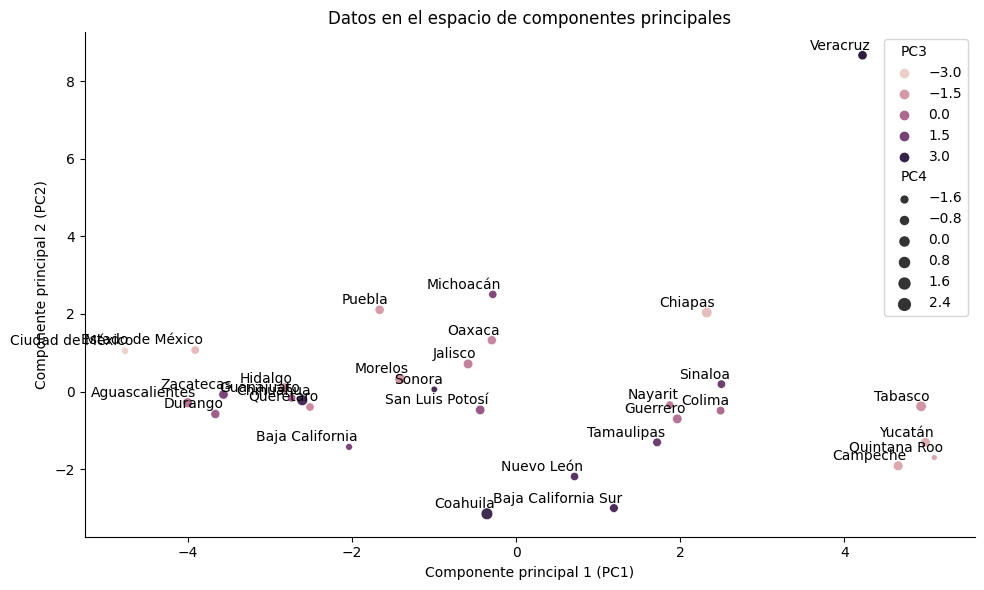

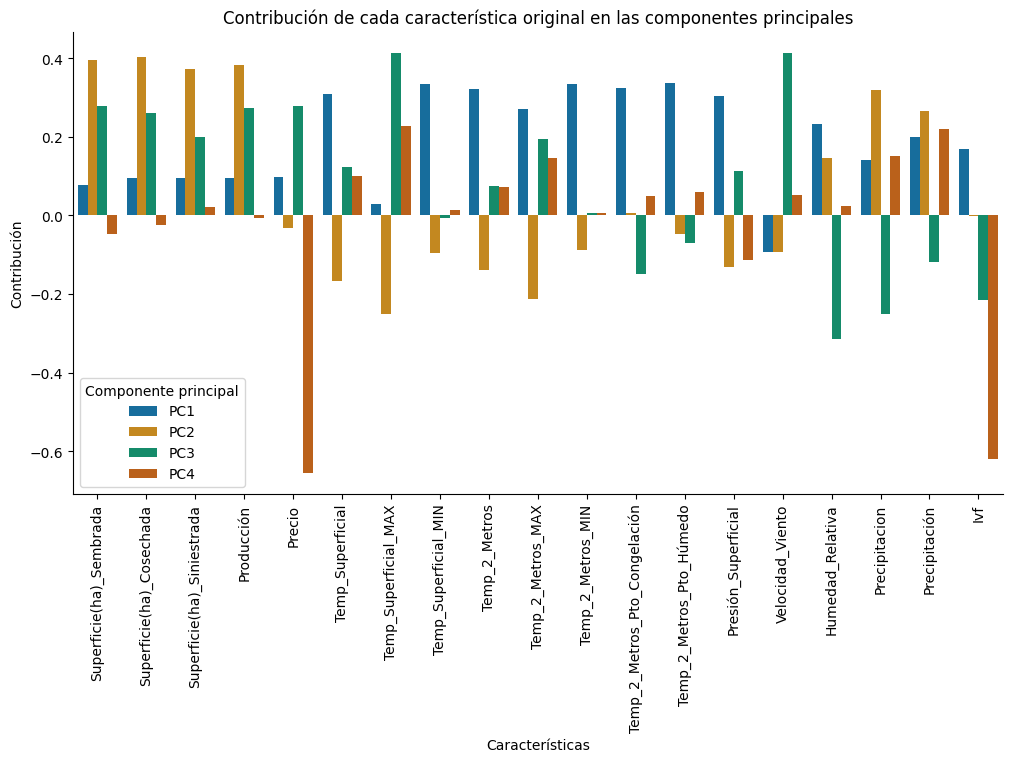


Contribuyentes de PC1:
Temp_2_Metros_Pto_Húmedo    0.335835
Temp_2_Metros_MIN           0.334803
Temp_Superficial_MIN        0.333681
Name: PC1, dtype: float64

Contribuyentes de PC2:
Superficie(ha)_Cosechada    0.403117
Superficie(ha)_Sembrada     0.396465
Producción                  0.382485
Name: PC2, dtype: float64

Contribuyentes de PC3:
Temp_Superficial_MAX    0.413458
Velocidad_Viento        0.413366
Humedad_Relativa        0.313474
Name: PC3, dtype: float64

Contribuyentes de PC4:
Precio                  0.655347
Ivf                     0.620865
Temp_Superficial_MAX    0.226333
Name: PC4, dtype: float64


In [154]:
# Aplicamos PCA
pca4_state = PCA(n_components=4)
x_pca4_state = pca4_state.fit_transform(df_to_pca_state_scaled)

# Creamos un dataframe con las componentes principales
df_pca4_state = pd.DataFrame(x_pca4_state, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Agregamos los nombres de los estados
df_pca4_state_with_state = df_pca4_state.join(df_group_state['Estado'])

# Graficamos los componentes principial
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='PC3', size='PC4', data=df_pca4_state_with_state)
plt.title('Datos en el espacio de componentes principales')
plt.xlabel('Componente principal 1 (PC1)')
plt.ylabel('Componente principal 2 (PC2)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Etiquetas a los puntos
for i, row in df_pca4_state_with_state.iterrows():
    plt.annotate(row['Estado'], (row['PC1'], row['PC2']), textcoords="offset points", xytext=(6, 4), ha='right')


plt.tight_layout()
plt.show()


# Creamos un dataframe con las componentes principales
loadings_df4_state = pd.DataFrame(pca4_state.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df_to_pca_state.columns)

# Analizamos la contribución de cada característica original en las 
# componentes principales
plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='value', hue='variable', data=pd.melt(loadings_df4_state.reset_index(), id_vars='index'))
plt.title('Contribución de cada característica original en las componentes principales')
plt.xlabel('Características')
plt.ylabel('Contribución')
plt.xticks(rotation=90)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(title='Componente principal')
plt.show()

# Principales contribuyentes en las componentes principales
loadings_df_abs_sorted_pc1_state = loadings_df4_state['PC1'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc2_state = loadings_df4_state['PC2'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc3_state = loadings_df4_state['PC3'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc4_state = loadings_df4_state['PC4'].abs().sort_values(ascending=False)

print("\nContribuyentes de PC1:")
print(loadings_df_abs_sorted_pc1_state[:3])

print("\nContribuyentes de PC2:")
print(loadings_df_abs_sorted_pc2_state[:3])

print("\nContribuyentes de PC3:")
print(loadings_df_abs_sorted_pc3_state[:3])

print("\nContribuyentes de PC4:")
print(loadings_df_abs_sorted_pc4_state[:3])

### Agrupación por cultivo

Agrupando por cultivos encontramos que, con 5 componentes explicamos alrededor del 90% de la varianza. Sin embargo, del análisis no se observa una relación evidente como cuando agrupamos por estado.

Varianza explicada acumulada:
[0.44494405 0.64661148 0.78974677 0.85735349 0.90488077 0.94261408
 0.97341866 0.98700381 0.99476665 0.99795675 0.99932036 0.999658
 0.99987491 0.99996565 0.99999232 0.9999968  0.9999992  1.
 1.        ]


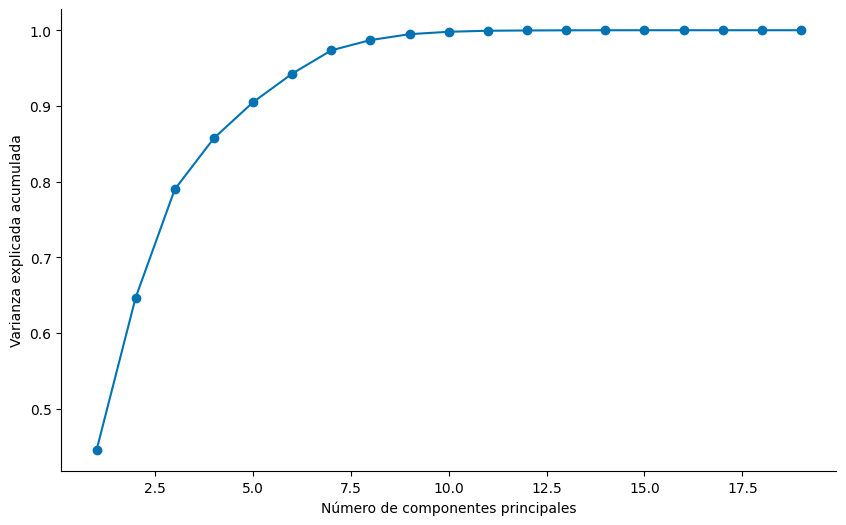

In [155]:
# Eliminamos columnas 
df_group_crop = df_SIAP_sniim_clima_precip_ivf.drop(['Año', 'Mes', 'Rendimiento(udm/ha)', 
                                                      'Estado_CVE', 'Estado'], axis=1)


# Funciones de agregación 
default_aggregation_function = 'mean'
specific_aggregations = {
    'Superficie(ha)_Sembrada': 'sum',
    'Superficie(ha)_Cosechada': 'sum',
    'Superficie(ha)_Siniestrada': 'sum',
    'Producción': 'sum', 
    'Precipitación': 'sum',
    'Precipitacion': 'sum'
}
aggregation_functions = {col: specific_aggregations.get(col, default_aggregation_function) for col in df_group_crop.columns}
aggregation_functions.pop('Cultivo')

# Hacemos la agrupación porcultivo
df_group_crop = df_group_crop.groupby(['Cultivo']).agg(aggregation_functions).reset_index()
df_to_pca_crop = df_group_crop.drop('Cultivo', axis=1)

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
df_to_pca_crop = pd.DataFrame(imputer.fit_transform(df_to_pca_crop), columns=df_to_pca_crop.columns)

# Estandarizamos a media 0 y varianza 1
scaler_crop = StandardScaler()
df_to_pca_crop_scaled = scaler_crop.fit_transform(df_to_pca_crop)

# Aplicamos PCA
pca_crop = PCA()
pca_crop.fit_transform(df_to_pca_crop_scaled)


# Obtenemos la varianza explicada acumulada
explained_variance_ratio = pca_crop.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print("Varianza explicada acumulada:")
print(cumulative_variance_ratio)

# Graficamos
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)
plt.show()

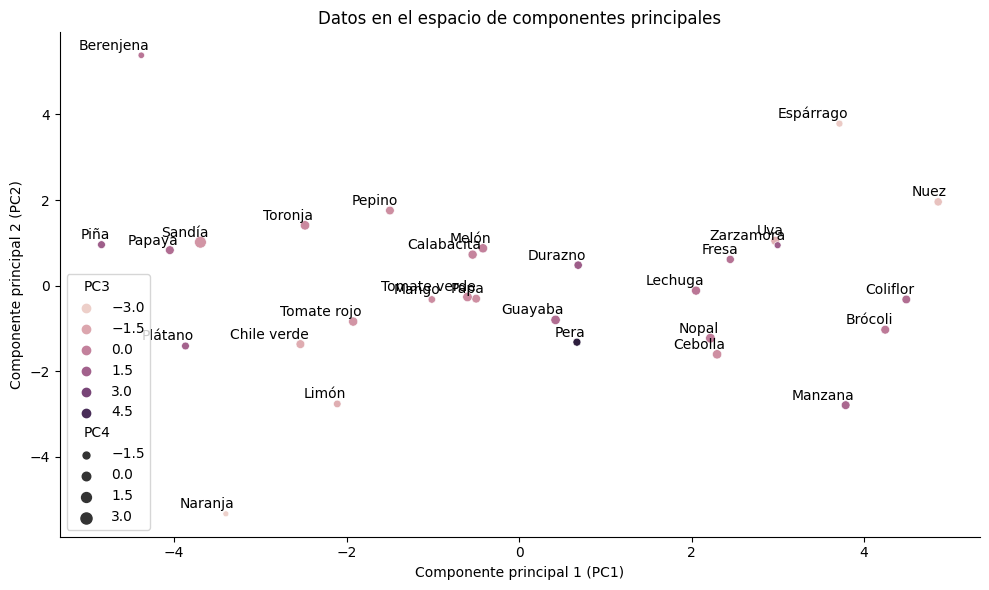

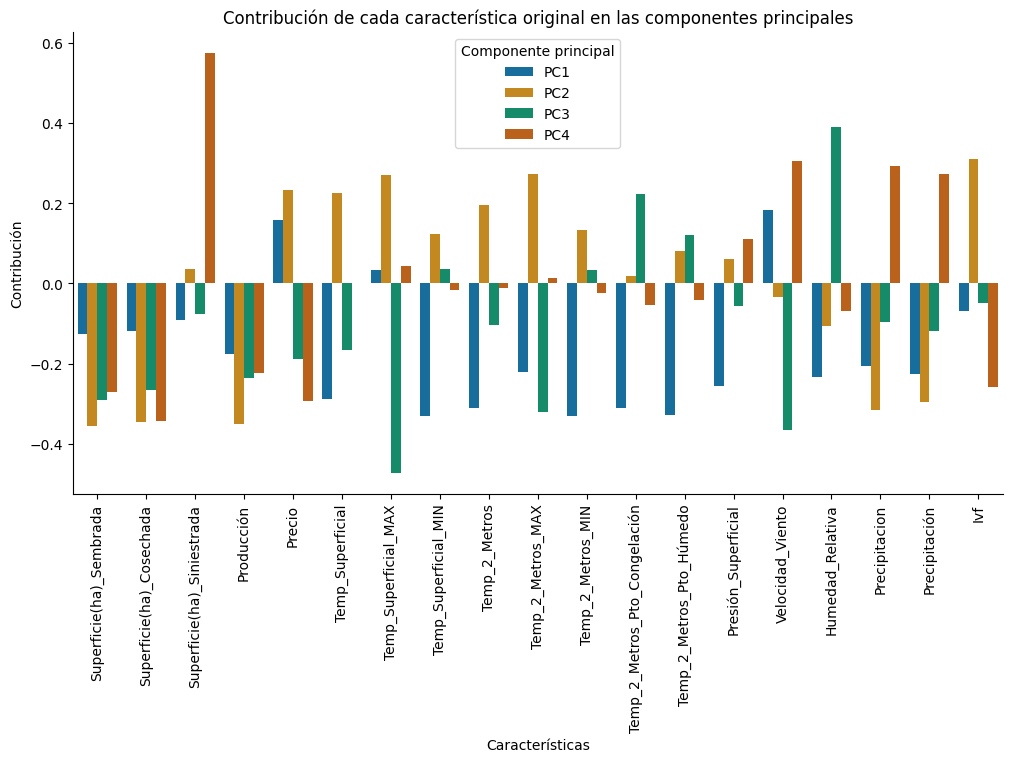


Contribuyentes de PC1:
Temp_Superficial_MIN        0.331424
Temp_2_Metros_MIN           0.329672
Temp_2_Metros_Pto_Húmedo    0.328323
Name: PC1, dtype: float64

Contribuyentes de PC2:
Superficie(ha)_Sembrada     0.355465
Producción                  0.351119
Superficie(ha)_Cosechada    0.346952
Name: PC2, dtype: float64

Contribuyentes de PC3:
Temp_Superficial_MAX    0.472632
Humedad_Relativa        0.390663
Velocidad_Viento        0.365327
Name: PC3, dtype: float64

Contribuyentes de PC4:
Superficie(ha)_Siniestrada    0.574558
Superficie(ha)_Cosechada      0.342870
Velocidad_Viento              0.304519
Name: PC4, dtype: float64


In [156]:
# Aplicamos PCA
pca4_crop = PCA(n_components=4)
x_pca4_crop = pca4_crop.fit_transform(df_to_pca_crop_scaled)

# Creamos un dataframe con las componentes principales
df_pca4_crop = pd.DataFrame(x_pca4_crop, columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Agregamos los nombres de los cultivos
df_pca4_crop_with_crop = df_pca4_crop.join(df_group_crop['Cultivo'])

# Graficamos los componentes principial
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='PC3', size='PC4', data=df_pca4_crop_with_crop)
plt.title('Datos en el espacio de componentes principales')
plt.xlabel('Componente principal 1 (PC1)')
plt.ylabel('Componente principal 2 (PC2)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

# Etiquetas a los puntos
for i, row in df_pca4_crop_with_crop.iterrows():
    plt.annotate(row['Cultivo'], (row['PC1'], row['PC2']), textcoords="offset points", xytext=(6, 4), ha='right')


plt.tight_layout()
plt.show()


# Creamos un dataframe con las componentes principales
loadings_df4_crop = pd.DataFrame(pca4_crop.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df_to_pca_crop.columns)

# Analizamos la contribución de cada característica original en las 
# componentes principales
plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='value', hue='variable', data=pd.melt(loadings_df4_crop.reset_index(), id_vars='index'))
plt.title('Contribución de cada característica original en las componentes principales')
plt.xlabel('Características')
plt.ylabel('Contribución')
plt.xticks(rotation=90)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(title='Componente principal')
plt.show()

# Principales contribuyentes en las componentes principales
loadings_df_abs_sorted_pc1_crop = loadings_df4_crop['PC1'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc2_crop = loadings_df4_crop['PC2'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc3_crop = loadings_df4_crop['PC3'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc4_crop = loadings_df4_crop['PC4'].abs().sort_values(ascending=False)

print("\nContribuyentes de PC1:")
print(loadings_df_abs_sorted_pc1_crop[:3])

print("\nContribuyentes de PC2:")
print(loadings_df_abs_sorted_pc2_crop[:3])

print("\nContribuyentes de PC3:")
print(loadings_df_abs_sorted_pc3_crop[:3])

print("\nContribuyentes de PC4:")
print(loadings_df_abs_sorted_pc4_crop[:3])

### Sin agrupación

Sin agrupar no encontramos ninguna relación evidente, y para explicar el 90% de la varianza, como con los otros análisis, necesitamos por lo menos 12 componentes principales.

Varianza explicada acumulada:
[0.29198023 0.43933648 0.5231933  0.59181063 0.64297747 0.68877159
 0.72947969 0.76952671 0.80856178 0.84463736 0.87750611 0.90842975
 0.93654611 0.96248545 0.97626491 0.98836053 0.99721399 0.99859027
 0.99917465 0.99957615 0.99980086 0.99992178 0.99999077 1.
 1.        ]


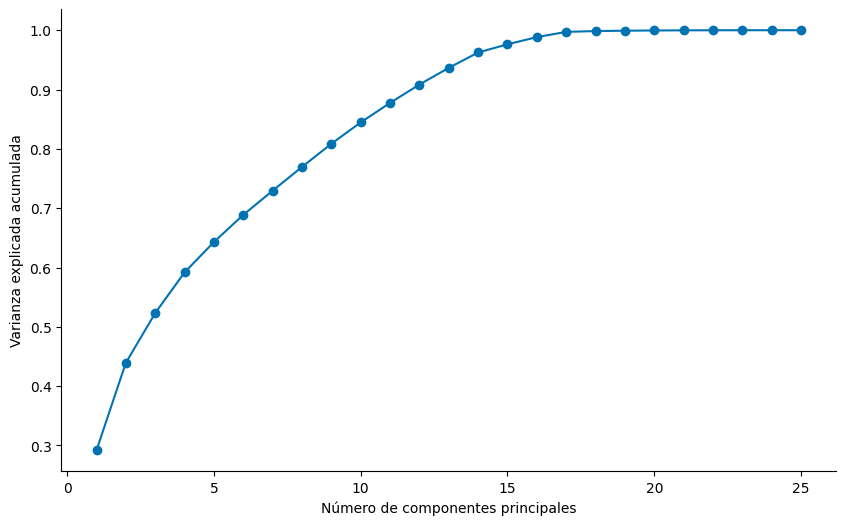

In [157]:
# Seleccionamos columnas numéricas
columns_numeric = df_SIAP_sniim_clima_precip_ivf.select_dtypes(include='number').columns
df_to_pca = df_SIAP_sniim_clima_precip_ivf[columns_numeric].copy()

# Codificamos las variables categóricas
label_encoder = LabelEncoder()
df_to_pca['Estado'] = label_encoder.fit_transform(df_SIAP_sniim_clima_precip_ivf['Estado'])
df_to_pca['Cultivo'] = label_encoder.fit_transform(df_SIAP_sniim_clima_precip_ivf['Cultivo'])

# Imputar valores faltantes
imputer = SimpleImputer(strategy='mean')
df_to_pca = pd.DataFrame(imputer.fit_transform(df_to_pca), columns=df_to_pca.columns)

# Estandarizamos a media 0 y varianza 1
scaler = StandardScaler()
df_to_pca_scaled = scaler.fit_transform(df_to_pca)

# Aplicamos PCA
pca = PCA()
pca.fit_transform(df_to_pca_scaled)

# Obtenemos la varianza explicada acumulada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()
print("Varianza explicada acumulada:")
print(cumulative_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza explicada acumulada')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(False)
plt.show()

Con 2 componentes principales solo explicamos el 43% de los datos, es un porcentaje bajo y al explorar solo usando estos componentes no se obtiene información relevante como se puede ver en la siguiente celda.

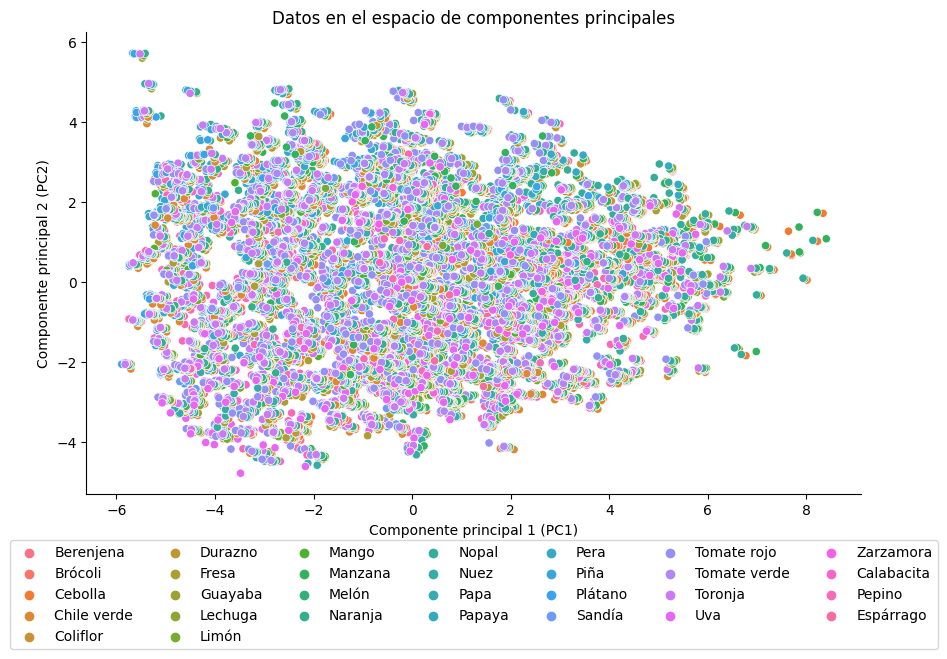

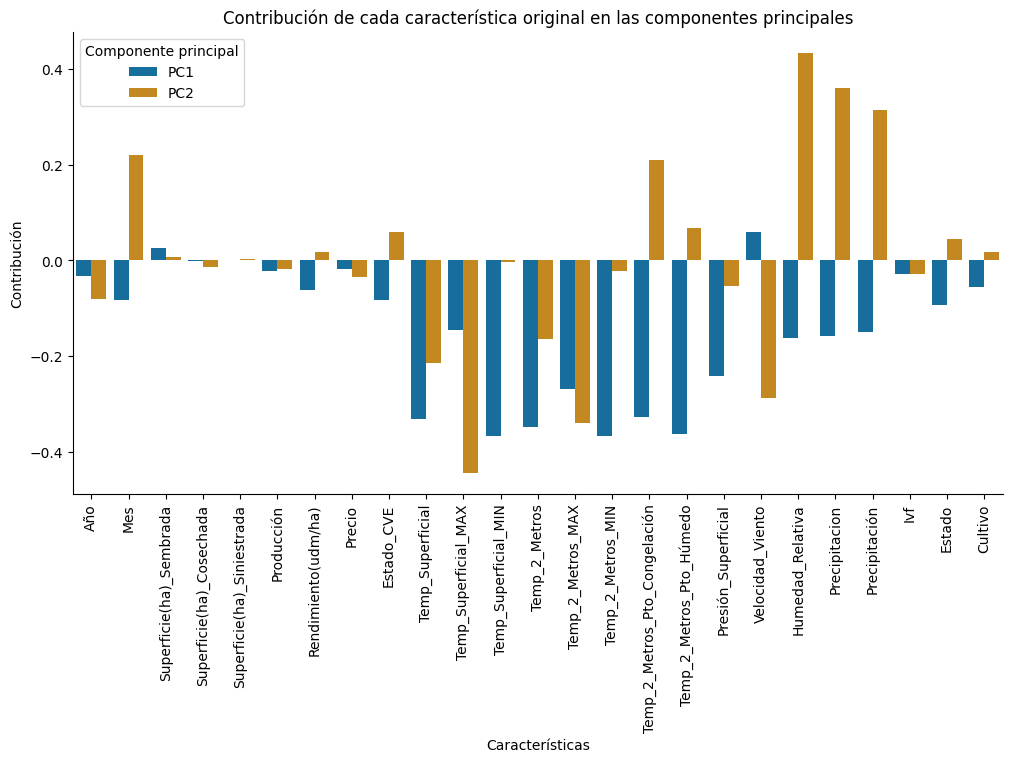


Contribuyentes de PC1:
Temp_Superficial_MIN        0.366771
Temp_2_Metros_MIN           0.366714
Temp_2_Metros_Pto_Húmedo    0.362602
Name: PC1, dtype: float64

Contribuyentes de PC2:
Temp_Superficial_MAX    0.444551
Humedad_Relativa        0.433394
Precipitacion           0.360582
Name: PC2, dtype: float64


In [158]:
# Aplicamos PCA
pca2 = PCA(n_components=2)
x_pca2 = pca2.fit_transform(df_to_pca_scaled)

# Creamos un dataframe con las componentes principales
df_pca2 = pd.DataFrame(x_pca2, columns=['PC1', 'PC2'])

# Graficamos el espacio de componentes principales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca2, hue=df_SIAP_sniim_clima_precip_ivf['Cultivo'])
plt.title('Datos en el espacio de componentes principales')
plt.xlabel('Componente principal 1 (PC1)')
plt.ylabel('Componente principal 2 (PC2)')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend( loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=7)

plt.show()

# Analizamos la contribución de cada característica original en las 
# componentes principales
loadings_df2 = pd.DataFrame(pca2.components_.T, columns=['PC1', 'PC2'], index=df_to_pca.columns)

plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='value', hue='variable', data=pd.melt(loadings_df2.reset_index(), id_vars='index'))
plt.title('Contribución de cada característica original en las componentes principales')
plt.xlabel('Características')
plt.ylabel('Contribución')
plt.xticks(rotation=90)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(title='Componente principal')
plt.show()

# Principales contribuyentes en las componentes principales
loadings_df_abs_sorted_pc1 = loadings_df2['PC1'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc2 = loadings_df2['PC2'].abs().sort_values(ascending=False)

print("\nContribuyentes de PC1:")
print(loadings_df_abs_sorted_pc1[:3])

print("\nContribuyentes de PC2:")
print(loadings_df_abs_sorted_pc2[:3])

Por otro lado, encontramos que con 5 componentes principales ya existe un componente principal que relacione el precio con el cultivo y el rendimiento, que es algo de interés para el cliente. Además, estos 5 explican el 64% de la varianza.

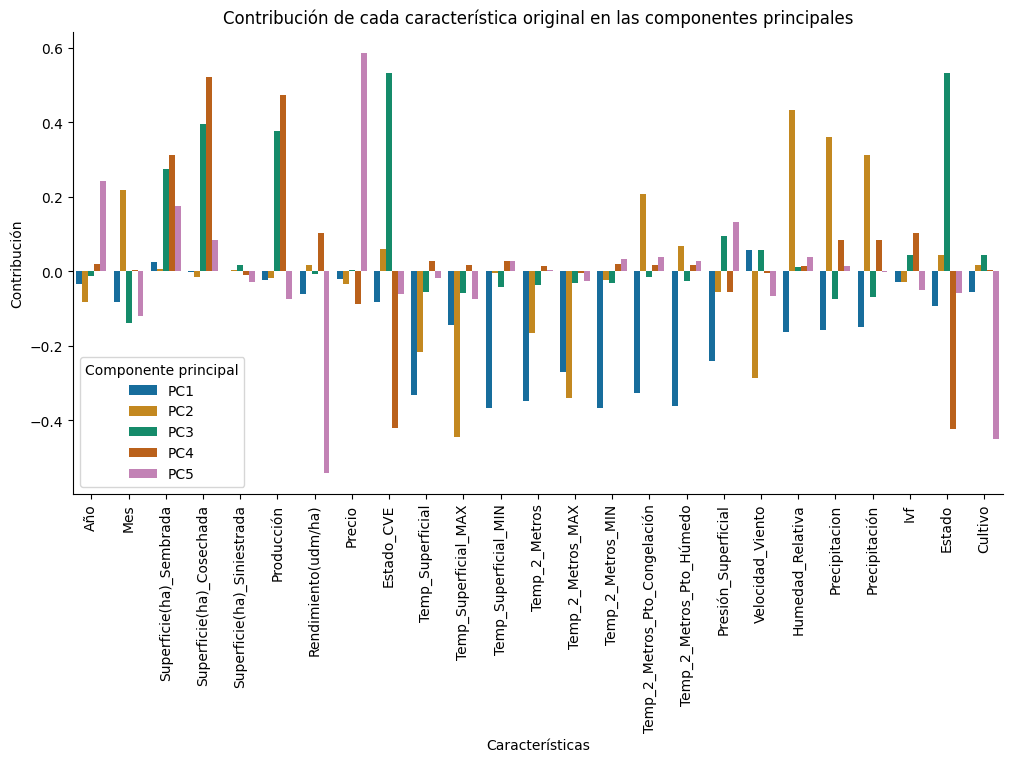


Contribuyentes de PC1:
Temp_Superficial_MIN        0.366771
Temp_2_Metros_MIN           0.366714
Temp_2_Metros_Pto_Húmedo    0.362602
Name: PC1, dtype: float64

Contribuyentes de PC2:
Temp_Superficial_MAX    0.444551
Humedad_Relativa        0.433394
Precipitacion           0.360583
Name: PC2, dtype: float64

Contribuyentes de PC3:
Estado_CVE                  0.533678
Estado                      0.531861
Superficie(ha)_Cosechada    0.395734
Name: PC3, dtype: float64

Contribuyentes de PC4:
Superficie(ha)_Cosechada    0.521331
Producción                  0.473705
Estado                      0.422703
Name: PC4, dtype: float64

Contribuyentes de PC5:
Precio                 0.586669
Rendimiento(udm/ha)    0.540974
Cultivo                0.449100
Name: PC5, dtype: float64


In [159]:
# Aplicamos PCA
pca5 = PCA(n_components=5)
x_pca5 = pca5.fit_transform(df_to_pca_scaled)

# Creamos un dataframe con las componentes principales
loadings_df5 = pd.DataFrame(pca5.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5'], index=df_to_pca.columns)

# Analizamos la contribución de cada característica original en las 
# componentes principales
plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='value', hue='variable', data=pd.melt(loadings_df5.reset_index(), id_vars='index'))
plt.title('Contribución de cada característica original en las componentes principales')
plt.xlabel('Características')
plt.ylabel('Contribución')
plt.xticks(rotation=90)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.legend(title='Componente principal')
plt.show()

# Principales contribuyentes en las componentes principales
loadings_df_abs_sorted_pc1 = loadings_df5['PC1'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc2 = loadings_df5['PC2'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc3 = loadings_df5['PC3'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc4 = loadings_df5['PC4'].abs().sort_values(ascending=False)
loadings_df_abs_sorted_pc5 = loadings_df5['PC5'].abs().sort_values(ascending=False)

print("\nContribuyentes de PC1:")
print(loadings_df_abs_sorted_pc1[:3])

print("\nContribuyentes de PC2:")
print(loadings_df_abs_sorted_pc2[:3])

print("\nContribuyentes de PC3:")
print(loadings_df_abs_sorted_pc3[:3])

print("\nContribuyentes de PC4:")
print(loadings_df_abs_sorted_pc4[:3])

print("\nContribuyentes de PC5:")
print(loadings_df_abs_sorted_pc5[:3])